In [1]:
import pandas as pd
import numpy as np
import pyodbc
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [2]:
import getpass
#conexão com o dataWarehouse
server = 'localhost' 
database = 'dataWarehouse2' 
username = 'sapiens' 
password =  getpass.getpass()
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()


········


In [50]:
#carrega a dim_cliente
query = "select cod_cliente,  MAX(data_venda) as LastInvoiceDate, MIN(data_venda) FirstInvoiceDate,  count(distinct numero_nfv) as Frequency, SUM(valor_fat_total_produto_nfv) as MonetaryValue from fato_venda inner join dim_nfv on fato_venda.SK_nfv = dim_nfv.SK_nfv where cod_filial in (2,3) group by cod_cliente;"
df = pd.read_sql(query, cnxn)
#dim_cliente = pd.read_sql(queryDC, cnxn)


In [51]:
customer_data = df.rename(columns={"cod_cliente":"CustomerID"})

In [52]:
customer_data.LastInvoiceDate = pd.to_datetime(customer_data.LastInvoiceDate)
customer_data.FirstInvoiceDate = pd.to_datetime(customer_data.FirstInvoiceDate)
customer_data.dtypes

CustomerID                   int64
LastInvoiceDate     datetime64[ns]
FirstInvoiceDate    datetime64[ns]
Frequency                    int64
MonetaryValue              float64
dtype: object

In [53]:
from datetime import timedelta
snapshot_date = customer_data["LastInvoiceDate"].max() + timedelta(days=1)
customer_data["Recency"] = (snapshot_date - customer_data['LastInvoiceDate']).dt.days

In [54]:
customer_data["RecencyScore"] = pd.cut(customer_data["Recency"], 
                                       bins=[-1, 
                                         np.percentile(customer_data["Recency"], 25), 
                                             np.percentile(customer_data["Recency"], 50), 
                                             np.percentile(customer_data["Recency"], 75), 
                                             customer_data["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")
customer_data["FrequencyScore"] = pd.cut(customer_data["Frequency"], 
                                       bins=[-1, 
                                         np.percentile(customer_data["Frequency"], 25), 
                                             np.percentile(customer_data["Frequency"], 50), 
                                             np.percentile(customer_data["Frequency"], 75), 
                                             customer_data["Frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["MonetaryScore"] = pd.cut(customer_data["MonetaryValue"], 
                                       bins=[-1, 
                                         np.percentile(customer_data["MonetaryValue"], 25), 
                                             np.percentile(customer_data["MonetaryValue"], 50), 
                                             np.percentile(customer_data["MonetaryValue"], 75), 
                                             customer_data["MonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")


In [55]:
customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]

In [56]:
customer_data.head()

,CustomerID,LastInvoiceDate,FirstInvoiceDate,Frequency,MonetaryValue,Recency,RecencyScore,FrequencyScore,MonetaryScore,RFM
0,15320,2018-10-26,2018-10-26,1,950.0,1108,3,1,2,6
1,6830,2021-09-24,2018-11-26,20,419439.0,44,4,4,4,12
2,15011,2021-09-24,2018-06-27,11,23892.2,44,4,3,4,11
3,15343,2018-11-09,2018-11-09,1,530.0,1094,3,1,1,5
4,8064,2014-01-18,2013-11-29,2,1198.1,2850,1,1,2,4


In [58]:
customer_data["Lifetime"] = (snapshot_date - customer_data['FirstInvoiceDate']).dt.days

In [67]:
customer_data["RelFrequency"] = customer_data["Frequency"] / customer_data["Lifetime"]
customer_data["RelFrequency"].apply(lambda x: np.isinf(x)).value_counts()

False    4480
Name: RelFrequency, dtype: int64

<AxesSubplot:>

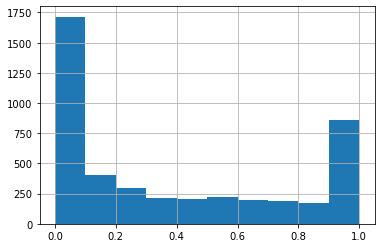

In [65]:
customer_data["RelRecency"] = 1 - customer_data["Recency"] / customer_data["Lifetime"]
customer_data["RelRecency"].hist()


In [42]:
customer_data["FrequencyScore"] = pd.cut(customer_data["RelFrequency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelFrequency"], 25), 
                                             np.percentile(customer_data["RelFrequency"], 50), 
                                             np.percentile(customer_data["RelFrequency"], 75), 
                                             customer_data["RelFrequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

In [60]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Monthly Customer Intakes')

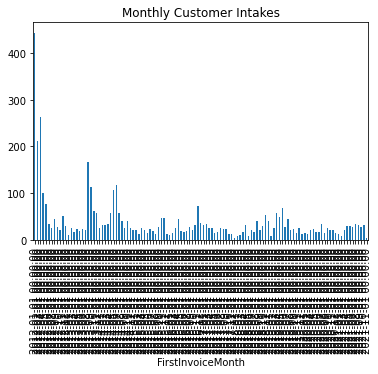

In [61]:
customer_data["FirstInvoiceMonth"] = customer_data["FirstInvoiceDate"].apply(lambda x: x.replace(day=1))
customer_data.groupby(["FirstInvoiceMonth"]).count()["FirstInvoiceDate"].plot(kind="bar")
plt.title("Monthly Customer Intakes")

<AxesSubplot:>

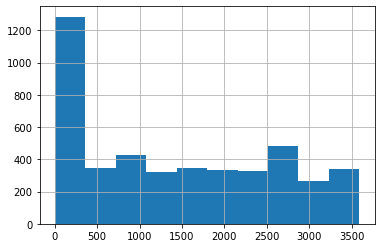

In [62]:
customer_data["Recency"].hist()


In [63]:
customer_data["Lifetime"].describe()

count    4480.000000
mean     2325.437054
std      1116.999037
min         1.000000
25%      1321.000000
50%      2692.000000
75%      3425.000000
max      3596.000000
Name: Lifetime, dtype: float64

In [66]:
customer_data["RelRecency"].describe()

count    4480.000000
mean        0.380765
std         0.379399
min         0.000000
25%         0.011798
50%         0.237072
75%         0.758592
max         0.999721
Name: RelRecency, dtype: float64

In [70]:
customer_data["RelFrequency"].describe()

count    4480.000000
mean        0.008639
std         0.022667
min         0.000279
25%         0.001006
50%         0.003190
75%         0.010448
max         1.000000
Name: RelFrequency, dtype: float64

<AxesSubplot:>

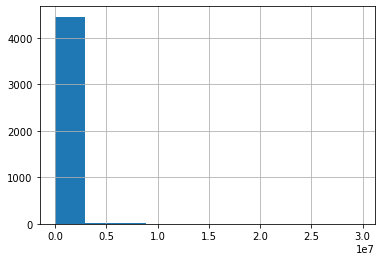

In [71]:
customer_data["MonetaryValue"].hist()

In [82]:
np.percentile(customer_data["MonetaryValue"], 99)

747890.2779999939

In [72]:
len(customer_data)

4480

<ipython-input-83-b3bc704e4760>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["RelMonetaryValue"] = customer_data["MonetaryValue"] / customer_data["Lifetime"]


<AxesSubplot:>

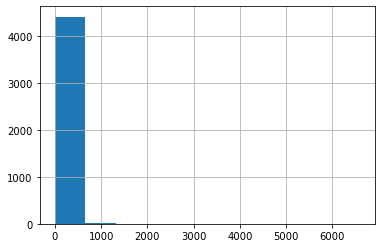

In [83]:
customer_data["RelMonetaryValue"] = customer_data["MonetaryValue"] / customer_data["Lifetime"]
customer_data["RelMonetaryValue"].hist()

In [74]:
customer_data["RelMonetaryValue"].describe()

count     4480.000000
mean        45.926421
std        324.466405
min          0.000000
25%          0.498829
50%          2.470889
75%         11.647798
max      12608.151681
Name: RelMonetaryValue, dtype: float64

In [81]:
sum(customer_data["RelRecency"]==0) / len(customer_data) # 23,8% com uma transacao

0.2408117249154453

In [80]:
customer_data = customer_data[customer_data["MonetaryValue"]<=np.percentile(customer_data["MonetaryValue"], 99)]

In [75]:
customer_data["RFM"].value_counts()

5     558
12    510
6     507
7     464
8     449
3     438
4     433
9     401
10    399
11    321
Name: RFM, dtype: int64

In [76]:
rfm_abs = pd.DataFrame(customer_data.pivot_table(index=["RFM"], 
                                    values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "MonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_abs

Frequency             Lifetime                    MonetaryValue           \
         amax amin median     amax  amin count median          amax     amin   
RFM                                                                            
3           2    1      1     3589  2472   438   3011        939.60     26.0   
4           5    1      1     3586  1278   433   2263       3523.00     86.0   
5           9    1      2     3595   198   558   2005      16750.00      0.0   
6          16    1      3     3595     1   507   1962     196000.00    124.0   
7          17    1      4     3595     2   464   2215     207000.00    509.5   
8          48    1      7     3595     9   449   2372     560973.14    956.5   
9          75    1     11     3595     9   401   2543     660078.00   1107.2   
10        184    3     20     3595    51   399   2935    8448005.85   3704.3   
11        187    6     31     3596   107   321   2813   18060531.50   4695.6   
12        486   19     63     3596   373   510   3013   29667692.64  19932.5   

              Recency                  
       median    amax    amin  median  
RFM                                    
3      350.78  3589.0  2472.0  2997.0  
4      621.00  3575.0  1278.0  2235.0  
5     1022.25  3562.0   198.0  1797.0  
6     1812.50  3539.0     1.0  1584.0  
7     3379.00  3463.0     1.0  1350.5  
8     5958.00  3418.0     1.0  1255.0  
9    10167.50  3182.0     2.0   905.0  
10   21405.50  2411.0     1.0   786.0  
11   39768.60  1250.0     1.0   179.0  
12   99318.94   191.0     1.0    30.0

In [77]:
customer_data["RecencyScore"] = pd.cut(customer_data["RelRecency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelRecency"], 25), 
                                             np.percentile(customer_data["RelRecency"], 50), 
                                             np.percentile(customer_data["RelRecency"], 75), 
                                             customer_data["RelRecency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["RecencyScore"].value_counts()

3    1121
1    1120
2    1120
4    1119
Name: RecencyScore, dtype: int64

In [78]:
customer_data["FrequencyScore"] = pd.cut(customer_data["RelFrequency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelFrequency"], 25), 
                                             np.percentile(customer_data["RelFrequency"], 50), 
                                             np.percentile(customer_data["RelFrequency"], 75), 
                                             customer_data["RelFrequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["FrequencyScore"].value_counts()

4    1120
1    1120
2    1120
3    1120
Name: FrequencyScore, dtype: int64

In [79]:
customer_data["MonetaryScore"] = pd.cut(customer_data["RelMonetaryValue"], 
                                       bins=[customer_data["RelMonetaryValue"].min()-1, 
                                             np.percentile(customer_data["RelMonetaryValue"], 25),
                                             np.percentile(customer_data["RelMonetaryValue"], 50), 
                                             np.percentile(customer_data["RelMonetaryValue"], 75), 
                                             customer_data["RelMonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["MonetaryScore"].value_counts()

4    1120
1    1120
2    1120
3    1120
Name: MonetaryScore, dtype: int64

In [84]:
customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]
customer_data["RFM"].value_counts()

<ipython-input-84-afe56cde84dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]


3     640
12    550
6     475
9     464
11    433
8     403
7     392
4     367
5     358
10    353
Name: RFM, dtype: int64

In [85]:
rfm_rel = pd.DataFrame(customer_data.pivot_table(index=["RFM"], 
                                    values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "MonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_rel
# Note that the median lifetime is rather constant across clusters. This is a good news - our segmentation is not biased by the lifetime
# of the customers.

Frequency             Lifetime                        MonetaryValue  \
         amax amin median     amax    amin  count  median          amax   
RFM                                                                       
3           3    1      1   3589.0  1052.0  640.0  2696.0       1740.00   
4           3    1      2   3595.0   338.0  367.0  2696.0       5775.00   
5          10    1      2   3595.0   341.0  358.0  2661.5      23400.00   
6          13    1      4   3595.0   114.0  475.0  2725.0     196000.00   
7          34    1      4   3589.0    79.0  392.0  2537.5     248639.90   
8          35    1      7   3595.0    23.0  403.0  2420.0     560973.14   
9          58    1     12   3595.0     1.0  464.0  2684.0     660078.00   
10         85    2     16   3595.0    25.0  353.0  2393.0    1063587.50   
11        145    2     33   3596.0    45.0  433.0  2858.0    1300921.10   
12        251    2     51   3596.0    23.0  550.0  2747.5    1529750.90   

                       Recency                  
        amin    median    amax    amin  median  
RFM                                             
3      26.00    349.25  3589.0  1052.0  2696.0  
4       0.00    900.00  3551.0   338.0  2636.0  
5     184.50   1073.25  3562.0   341.0  2301.5  
6     153.33   2260.00  3539.0   114.0  2293.0  
7     124.00   3782.05  3516.0     2.0  1493.0  
8     158.00   4545.00  3380.0    15.0  1102.0  
9     289.00  10277.89  3418.0     1.0   980.0  
10    356.00  14915.00  2692.0     1.0   417.0  
11    509.50  26755.30  2199.0     1.0   131.0  
12   1467.40  92433.75   863.0     1.0    31.5

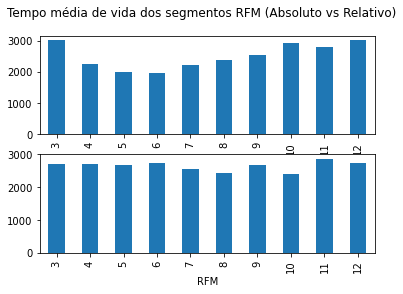

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Tempo média de vida dos segmentos RFM (Absoluto vs Relativo)')
rfm_abs["Lifetime"]["median"].plot(ax=axes[0], kind="bar")
rfm_rel["Lifetime"]["median"].plot(ax=axes[1], kind="bar")
plt.show()

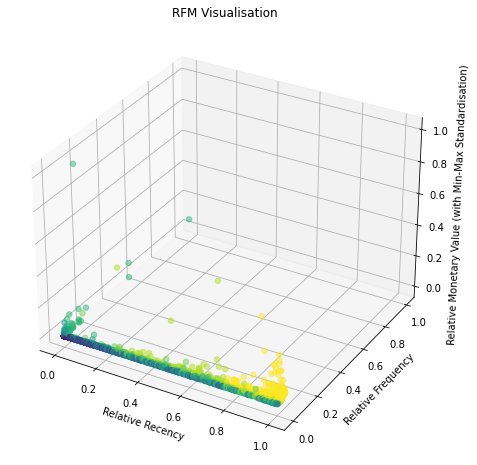

In [87]:
# Visualise segments using 3D plot
x = customer_data["RelRecency"]
y = customer_data["RelFrequency"]
z = (customer_data["RelMonetaryValue"] - customer_data["RelMonetaryValue"].min()) / customer_data["RelMonetaryValue"].max()
c = customer_data["RFM"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x, ys=y, zs=z, c=c, s=30, alpha=0.5)
ax.set_title("RFM Visualisation")
ax.set_xlabel("Relative Recency")
ax.set_ylabel("Relative Frequency")
ax.set_zlabel("Relative Monetary Value (with Min-Max Standardisation)")
plt.show()

Text(0.5, 1.0, 'Relative Recency (x) vs Relative Monetary Value (y)')

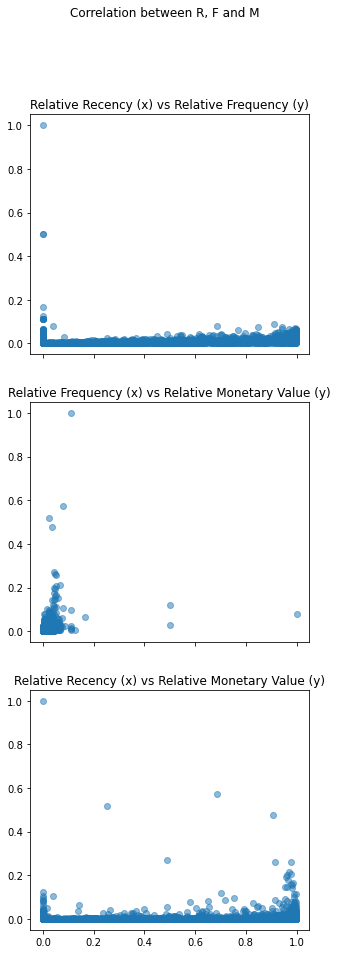

In [88]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(5, 15))
fig.suptitle('Correlation between R, F and M')

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_title("Relative Recency (x) vs Relative Frequency (y)")

axs[1].scatter(y, z, alpha=0.5)
axs[1].set_title("Relative Frequency (x) vs Relative Monetary Value (y)")

axs[2].scatter(x, z, alpha=0.5)
axs[2].set_title("Relative Recency (x) vs Relative Monetary Value (y)")

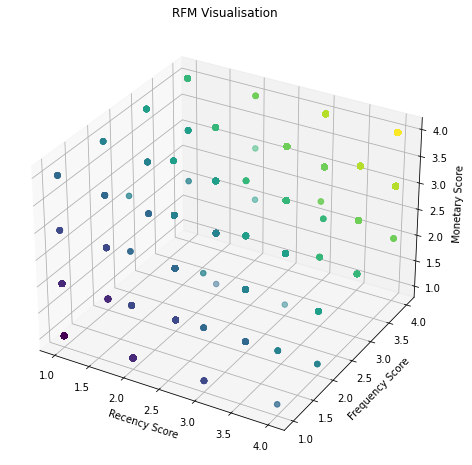

In [89]:
x = customer_data["RecencyScore"]
y = customer_data["FrequencyScore"]
z = customer_data["MonetaryScore"]
c = customer_data["RFM"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x, ys=y, zs=z, c=c, s=30, alpha=0.5)
ax.set_title("RFM Visualisation")
ax.set_xlabel("Recency Score")
ax.set_ylabel("Frequency Score")
ax.set_zlabel("Monetary Score")
plt.show()

In [90]:
customer_data.describe()

,CustomerID,Frequency,MonetaryValue,Recency,RecencyScore,FrequencyScore,MonetaryScore,RFM,Lifetime,RelFrequency,RelRecency,RelMonetaryValue
count,4435.000000,4435.000000,4.435000e+03,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000
mean,9266.893799,15.976099,3.928795e+04,1420.933258,2.485908,2.484780,2.484780,7.455468,2318.191432,0.008170,0.375425,27.397411
std,5453.219017,26.813071,1.269583e+05,1151.183247,1.114536,1.113509,1.113509,3.027611,1117.250890,0.021506,0.377245,163.225053
min,1.000000,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000279,0.000000,0.000000
25%,4809.000000,2.000000,9.197500e+02,205.000000,1.000000,1.000000,1.000000,5.000000,1291.500000,0.000993,0.010078,0.492496
50%,8747.000000,5.000000,3.781500e+03,1287.000000,2.000000,2.000000,2.000000,7.000000,2689.000000,0.003088,0.230232,2.358494
75%,14029.500000,17.000000,1.843990e+04,2473.000000,3.000000,3.000000,3.000000,10.000000,3414.000000,0.009998,0.742921,11.032182
max,19047.000000,251.000000,1.529751e+06,3589.000000,4.000000,4.000000,4.000000,12.000000,3596.000000,1.000000,0.999721,6581.000000


In [91]:
rfm_rel

Frequency             Lifetime                        MonetaryValue  \
         amax amin median     amax    amin  count  median          amax   
RFM                                                                       
3           3    1      1   3589.0  1052.0  640.0  2696.0       1740.00   
4           3    1      2   3595.0   338.0  367.0  2696.0       5775.00   
5          10    1      2   3595.0   341.0  358.0  2661.5      23400.00   
6          13    1      4   3595.0   114.0  475.0  2725.0     196000.00   
7          34    1      4   3589.0    79.0  392.0  2537.5     248639.90   
8          35    1      7   3595.0    23.0  403.0  2420.0     560973.14   
9          58    1     12   3595.0     1.0  464.0  2684.0     660078.00   
10         85    2     16   3595.0    25.0  353.0  2393.0    1063587.50   
11        145    2     33   3596.0    45.0  433.0  2858.0    1300921.10   
12        251    2     51   3596.0    23.0  550.0  2747.5    1529750.90   

                       Recency                  
        amin    median    amax    amin  median  
RFM                                             
3      26.00    349.25  3589.0  1052.0  2696.0  
4       0.00    900.00  3551.0   338.0  2636.0  
5     184.50   1073.25  3562.0   341.0  2301.5  
6     153.33   2260.00  3539.0   114.0  2293.0  
7     124.00   3782.05  3516.0     2.0  1493.0  
8     158.00   4545.00  3380.0    15.0  1102.0  
9     289.00  10277.89  3418.0     1.0   980.0  
10    356.00  14915.00  2692.0     1.0   417.0  
11    509.50  26755.30  2199.0     1.0   131.0  
12   1467.40  92433.75   863.0     1.0    31.5

In [102]:
customer_data["last_order_within_l80d"] = customer_data["Recency"]<180 # Had transactions in the last 60 days
customer_data["more_than_four_orders"] = customer_data["Frequency"]>3 # Logged in more than twice
customer_data["value_higher_than_14k"] = customer_data["MonetaryValue"]>14000 # Sum of value higher than 2K
customer_data.groupby(["last_order_within_l80d", "more_than_four_orders", "value_higher_than_14k"]).count()["Lifetime"]

<ipython-input-102-b3fe12c81fe3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["last_order_within_l80d"] = customer_data["Recency"]<180 # Had transactions in the last 60 days
<ipython-input-102-b3fe12c81fe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["more_than_four_orders"] = customer_data["Frequency"]>3 # Logged in more than twice
<ipython-input-102-b3fe12c81fe3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

last_order_within_l80d  more_than_four_orders  value_higher_than_14k
False                   False                  False                    1631
                                               True                       62
                        True                   False                    1091
                                               True                      595
True                    False                  False                     218
                                               True                       17
                        True                   False                     198
                                               True                      623
Name: Lifetime, dtype: int64

In [103]:
conditions = [
    (customer_data["last_order_within_l80d"]==True)&(customer_data["more_than_four_orders"]==True)&(customer_data["value_higher_than_14k"]==True),
    (customer_data["last_order_within_l80d"]==True)&(customer_data["more_than_four_orders"]==True)&(customer_data["value_higher_than_14k"]==False),
    (customer_data["last_order_within_l80d"]==True)&(customer_data["more_than_four_orders"]==False),
    (customer_data["last_order_within_l80d"]==False)&(customer_data["more_than_four_orders"]==True),
    (customer_data["last_order_within_l80d"]==False)&(customer_data["more_than_four_orders"]==False)
]

mappings = ["01. Alto Engajamento e Alto Valor", 
            "02. Alto Engajamento e Baixo Valor", 
            "03. Recente e Baixa Frequencia", 
            "04. Antigo e Alta Frequencia", 
            "05. Baixo Engajamento & Baixo Valor"]
customer_data['FinalRFM'] = np.select(conditions, mappings, default="Others")
customer_data['FinalRFM'].value_counts()

<ipython-input-103-a5050f4bc810>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data['FinalRFM'] = np.select(conditions, mappings, default="Others")


05. Baixo Engajamento & Baixo Valor    1693
04. Antigo e Alta Frequencia           1686
01. Alto Engajamento e Alto Valor       623
03. Recente e Baixa Frequencia          235
02. Alto Engajamento e Baixo Valor      198
Name: FinalRFM, dtype: int64

In [104]:
customer_data.pivot_table(index=["FinalRFM"], 
                          values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                          aggfunc={"Recency": [np.min, np.median, np.max], 
                                   "Frequency": [np.min, np.median, np.max], 
                                   "MonetaryValue": [np.min, np.median, np.max], 
                                   "Lifetime": [np.min, np.median, np.max, "count"]})

Frequency             Lifetime             \
                                         amax amin median     amax amin count   
FinalRFM                                                                        
01. Alto Engajamento e Alto Valor         251    4     50     3596   51   623   
02. Alto Engajamento e Baixo Valor         96    4      8     3589   65   198   
03. Recente e Baixa Frequencia              3    1      2     3523    1   235   
04. Antigo e Alta Frequencia              187    4     10     3596  289  1686   
05. Baixo Engajamento & Baixo Valor         3    1      1     3595  181  1693   

                                           MonetaryValue                     \
                                    median          amax     amin    median   
FinalRFM                                                                      
01. Alto Engajamento e Alto Valor     2951     1529750.9  14006.5  68943.30   
02. Alto Engajamento e Baixo Valor     905       13959.3    724.7   6136.85   
03. Recente e Baixa Frequencia         121       82500.0    124.0   1560.00   
04. Antigo e Alta Frequencia          2991     1300921.1    453.0   8192.40   
05. Baixo Engajamento & Baixo Valor   2319      254374.0      0.0    736.00   

                                    Recency              
                                       amax amin median  
FinalRFM                                                 
01. Alto Engajamento e Alto Valor       179    1     31  
02. Alto Engajamento e Baixo Valor      177    1     51  
03. Recente e Baixa Frequencia          179    1     64  
04. Antigo e Alta Frequencia           3516  184   1620  
05. Baixo Engajamento & Baixo Valor    3589  181   2179

In [105]:
customer_data.to_csv("RFM.csv")